In [60]:
# import libraries
import os
import pandas as pd
from pandas import DataFrame
import numpy as np
from sklearn.preprocessing import MinMaxScaler
#from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed

#tf.logging.set_verbosity(tf.logging.ERROR)
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, cohen_kappa_score, fbeta_score
from sklearn.metrics import recall_score, classification_report, auc, roc_curve, log_loss
LABELS = ["Normal","FMA"]

In [61]:
import time
#start = time.time()

In [62]:
#end = time.time()

In [63]:
#print("Time to compile model: ", end='')
#print(end - start)

In [65]:
import joblib

### **Cargar training y testing**

In [66]:
# Cargar training y testing
# Read in data and display first 5 rows
test = pd.read_csv("Dataset_Test.csv")
# validation
train = pd.read_csv("Dataset_Training.csv")
print('The shape of our train is:', train.shape)
#test.head(5)
train.head(5)

The shape of our train is: (13508, 13)


,temp_max,temp_avg,temp_min,prec,wd,ws,atmos_pres_avg,atmos_pres_min,atmos_pres_max,rh,ceil_hgt,visibility,FMA
0,13.0,11.333333,10.0,0.0,128.000000,7.2,1022.328571,1020.8,1023.8,82.216667,4116.666667,15383.33333,0
1,14.0,11.200000,10.0,3.0,312.500000,6.2,1020.375000,1018.8,1021.9,84.546667,16217.333330,12080.00000,0
2,15.0,11.952381,8.0,0.0,297.368421,9.2,1020.085714,1019.1,1021.9,83.685714,18158.235290,10523.80952,0
3,16.0,11.571429,8.0,0.0,270.000000,5.1,1022.650000,1021.6,1024.1,82.300000,22000.000000,10400.00000,0
4,16.0,13.368421,10.0,0.0,196.250000,4.1,1025.137500,1024.0,1027.3,77.289474,22000.000000,10915.78947,0


In [67]:
split = 1460 # Validation
validation = train[-split:]
train = train[:-split]

In [68]:
# The last element contains the labels
# Convertir Series to DataFrame (.to_frame())
train_fma = train.iloc[:, -1]
validation_fma = validation.iloc[:, -1]
test_fma = test.iloc[:, -1]

# Columnas
train_fma.columns = ['train_fma']
validation_fma.columns = ['validation_fma']
test_fma.columns = ['test_fma']

In [70]:
train_fma.shape

0    0
1    0
2    0
3    0
4    0
Name: FMA, dtype: int64

In [71]:
type(train_fma)

pandas.core.series.Series

https://www.tensorflow.org/guide/keras/train_and_evaluate#automatically_setting_apart_a_validation_holdout_set

### **Correlation**

In [72]:
test.corr()

,temp_max,temp_avg,temp_min,prec,wd,ws,atmos_pres_avg,atmos_pres_min,atmos_pres_max,rh,ceil_hgt,visibility,FMA
temp_max,1.000000,0.966484,0.848427,-0.159210,-0.073356,-0.130990,-0.424280,-0.412254,-0.415777,-0.598911,0.329616,0.218104,0.178918
temp_avg,0.966484,1.000000,0.926837,-0.136748,-0.065644,-0.119781,-0.432443,-0.407833,-0.439769,-0.584533,0.305710,0.177020,0.191701
temp_min,0.848427,0.926837,1.000000,-0.097743,0.022454,0.001391,-0.404744,-0.374556,-0.416388,-0.407796,0.148155,0.101752,0.166232
prec,-0.159210,-0.136748,-0.097743,1.000000,0.044079,0.171498,-0.184338,-0.202714,-0.168214,0.143424,-0.089518,-0.147923,0.548912
wd,-0.073356,-0.065644,0.022454,0.044079,1.000000,0.585838,-0.205109,-0.177743,-0.218977,0.339446,-0.347679,-0.131239,-0.059569
ws,-0.130990,-0.119781,0.001391,0.171498,0.585838,1.000000,-0.165851,-0.165184,-0.153477,0.297974,-0.313279,-0.220747,0.050279
atmos_pres_avg,-0.424280,-0.432443,-0.404744,-0.184338,-0.205109,-0.165851,1.000000,0.989287,0.982631,0.084061,-0.022277,0.089493,-0.255712
atmos_pres_min,-0.412254,-0.407833,-0.374556,-0.202714,-0.177743,-0.165184,0.989287,1.000000,0.951926,0.083771,-0.011292,0.059092,-0.265680
atmos_pres_max,-0.415777,-0.439769,-0.416388,-0.168214,-0.218977,-0.153477,0.982631,0.951926,1.000000,0.084612,-0.044934,0.136444,-0.240939
rh,-0.598911,-0.584533,-0.407796,0.143424,0.339446,0.297974,0.084061,0.083771,0.084612,1.000000,-0.574701,-0.401152,-0.186702


In [73]:
train.corr()

,temp_max,temp_avg,temp_min,prec,wd,ws,atmos_pres_avg,atmos_pres_min,atmos_pres_max,rh,ceil_hgt,visibility,FMA
temp_max,1.000000,0.967983,0.836402,-0.163948,0.007857,-0.098095,-0.282529,-0.250563,-0.300632,-0.642404,0.464038,0.018862,-0.030577
temp_avg,0.967983,1.000000,0.913765,-0.152308,-0.005849,-0.091864,-0.287509,-0.250416,-0.310994,-0.634377,0.406486,-0.007203,-0.013302
temp_min,0.836402,0.913765,1.000000,-0.113428,0.023558,-0.013548,-0.256721,-0.217456,-0.282916,-0.487860,0.215225,-0.090825,0.017220
prec,-0.163948,-0.152308,-0.113428,1.000000,0.043542,0.118050,-0.104669,-0.117185,-0.088026,0.149083,-0.157606,-0.118544,0.491282
wd,0.007857,-0.005849,0.023558,0.043542,1.000000,0.401938,-0.187118,-0.157188,-0.203705,0.268295,-0.212751,-0.046980,0.014710
ws,-0.098095,-0.091864,-0.013548,0.118050,0.401938,1.000000,-0.154113,-0.158659,-0.140079,0.169670,-0.227692,-0.204420,0.183870
atmos_pres_avg,-0.282529,-0.287509,-0.256721,-0.104669,-0.187118,-0.154113,1.000000,0.973289,0.981648,0.036510,-0.002517,0.155337,-0.221394
atmos_pres_min,-0.250563,-0.250416,-0.217456,-0.117185,-0.157188,-0.158659,0.973289,1.000000,0.921940,0.033917,0.007457,0.148326,-0.236685
atmos_pres_max,-0.300632,-0.310994,-0.282916,-0.088026,-0.203705,-0.140079,0.981648,0.921940,1.000000,0.039271,-0.017329,0.153202,-0.195605
rh,-0.642404,-0.634377,-0.487860,0.149083,0.268295,0.169670,0.036510,0.033917,0.039271,1.000000,-0.486370,-0.233402,0.021847


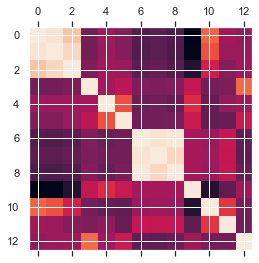

In [74]:
plt.matshow(train.corr())
plt.show()

### **Actualizar Datos**

In [75]:
# Eliminar Campos
test = test.drop(['temp_avg','temp_min', 'atmos_pres_min', 'wd', 'atmos_pres_max','atmos_pres_avg', 'rh','ceil_hgt', 'visibility', 'FMA'], axis=1) 
# ceil_hgt # visibility ,'temp_max','temp_min'

,temp_max,prec,ws
0,15.2,0.0,6.7
1,16.1,0.0,3.6
2,17.0,0.0,3.6
3,17.0,0.0,5.1
4,20.0,0.0,4.1


In [78]:
# Eliminar Campos
train = train.drop(['temp_avg','temp_min', 'atmos_pres_min', 'wd', 'atmos_pres_max','atmos_pres_avg', 'rh','ceil_hgt', 'visibility', 'FMA'], axis=1)

KeyError: "['temp_avg' 'temp_min' 'atmos_pres_min' 'wd' 'atmos_pres_max'\n 'atmos_pres_avg' 'rh' 'ceil_hgt' 'visibility' 'FMA'] not found in axis"

In [79]:
# Eliminar Campos
validation = validation.drop(['temp_avg','temp_min', 'atmos_pres_min', 'wd', 'atmos_pres_max','atmos_pres_avg', 
                              'rh','ceil_hgt', 'visibility', 'FMA'], axis=1)

KeyError: "['temp_avg' 'temp_min' 'atmos_pres_min' 'wd' 'atmos_pres_max'\n 'atmos_pres_avg' 'rh' 'ceil_hgt' 'visibility' 'FMA'] not found in axis"

In [80]:
# Descriptive statistics for each column
test.describe()

,temp_max,prec,ws
count,3261.000000,3261.000000,3261.000000
mean,20.218798,1.449525,8.102331
std,4.599993,6.848187,2.620314
min,9.000000,0.000000,2.600000
25%,17.000000,0.000000,6.200000
50%,20.000000,0.000000,7.700000
75%,23.000000,0.100000,9.800000
max,38.000000,198.000000,22.700000


In [82]:
print("Training dataset shape:", train.shape)
print("Validation dataset shape:", validation.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (12048, 3)
Validation dataset shape: (1460, 3)
Test dataset shape: (3261, 3)


In [83]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [84]:
# set random seed
import tensorflow as tf
tf.random.set_seed(123)

In [85]:
train.corr()

,temp_max,prec,ws
temp_max,1.000000,-0.163948,-0.098095
prec,-0.163948,1.000000,0.118050
ws,-0.098095,0.118050,1.000000


In [86]:
test.corr()

,temp_max,prec,ws
temp_max,1.00000,-0.159210,-0.130990
prec,-0.15921,1.000000,0.171498
ws,-0.13099,0.171498,1.000000


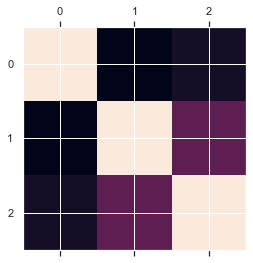

In [87]:
plt.matshow(train.corr())
plt.show()

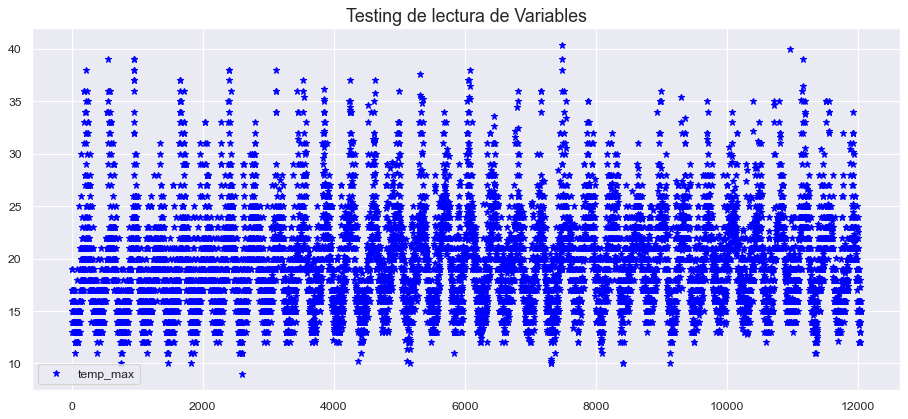

In [88]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['temp_max'], label='temp_max',  color='blue', animated = False,
        linestyle='None', marker='*', linewidth=0.5)
#ax.plot(train['temp_avg'], label='temp_avg', color='red', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Testing de lectura de Variables', fontsize=16)
plt.show()

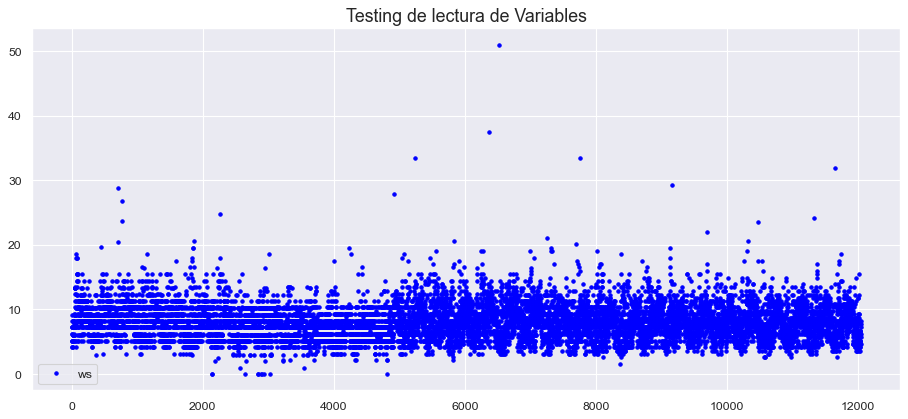

In [89]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['ws'], label='ws',  color='blue', animated = False,
        linestyle='None', marker='.', linewidth=0.5)
#ax.plot(train['temp_avg'], label='temp_avg', color='red', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Testing de lectura de Variables', fontsize=16)
plt.show()

## Normalize the data or Standardize the data ?

In [90]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
X_validation = scaler.transform(validation)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [94]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1]) # X_train 
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])     # X_test 
print("Test data shape:", X_test.shape)
X_validation = X_validation.reshape(X_validation.shape[0], 1, X_validation.shape[1])  #X_validation
print("Test data shape:", X_validation.shape)

Training data shape: (12048, 1, 3)
Test data shape: (3261, 1, 3)
Test data shape: (1460, 1, 3)


In [95]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(32, activation='relu', return_sequences=True,  #16
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(32, activation='relu', return_sequences=True)(L4) #16
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [96]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adamax', loss='mae', metrics=['mae', 'mse', 'mape', 'msle', 
                                                     'cosine_proximity']) #Error absoluto medio (mae), MeanSquaredError mse
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 3)]            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 32)             4608      
_________________________________________________________________
lstm_5 (LSTM)                (None, 4)                 592       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_7 (LSTM)                (None, 1, 32)             4736      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 3)             

In [97]:
# collect data across multiple repeats
dtrain = DataFrame()
val = DataFrame()
# fit the model to the data
for i in range(1):
    print("Fit model on training data...")
    start = time.time()
    nb_epochs = 100 # 100
    batch_size = 32 # 10 # 32 casi por defecto...
    #history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, validation_data=(X_test, X_test), shuffle=False,
    #                    verbose=0).history # we use 5% of the training data for validation 
                                                                  # after each epoch (validation_split = 0.05)
    history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                        validation_data=(X_validation, X_validation), verbose= 0).history # we use 5% of the training data for validation 
                                                                  # after each epoch (validation_split = 0.05)    # validation_data=X_validation
                        # validation_data=(X_validation, X_validation)
    end = time.time()
    # story history
    dtrain[str(i)] = history['loss']
    val[str(i)] = history['val_loss']
    print("Time to training model: ", end='')
    print(end - start)

Fit model on training data...
Time to training model: 141.33727288246155


In [98]:
X_train.shape

(12048, 1, 3)

                0
count  100.000000
mean     0.016915
std      0.006924
min      0.015620
25%      0.015670
50%      0.015686
75%      0.015731
max      0.076978


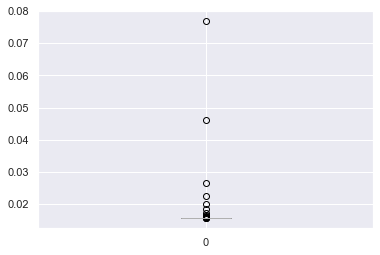

In [99]:
print(dtrain.describe())
dtrain.boxplot()
plt.show()

In [100]:
# print the best MSE reached on the test set
print("Best MSE on Validation Set =", max(history['val_mae']))

Best MSE on Validation Set = 0.05058044195175171


In [ ]:
#print("#########################################################")
#loss = model.evaluate(X_train, X_train, verbose=0)
#print(loss)

In [ ]:
#print(model.metrics_names)

In [101]:
loss = model.evaluate(X_test, X_test, verbose=0)
print(loss)

[0.015091960318386555, 0.015091960318386555, 0.0009262273670174181, 86703.8203125, 0.0006859079003334045, 0.9914331436157227]


In [103]:
print('loss', loss[0])
print('mae', loss[1])
print('mse', loss[2])
print('mape', loss[3])
print('msle', loss[4])
print('cosine_proximity', loss[5])

loss 0.015091960318386555
mae 0.015091960318386555
mse 0.0009262273670174181
mape 86703.8203125
msle 0.0006859079003334045
cosine_proximity 0.9914331436157227


In [104]:
# Mejor !!!
for name, value in zip(model.metrics_names, loss):
    print(name, value)

loss 0.015091960318386555
mae 0.015091960318386555
mse 0.0009262273670174181
mape 86703.8203125
msle 0.0006859079003334045
cosine_proximity 0.9914331436157227


In [ ]:
| A | B | C |
|---|---|---|
| 2 | 2 | 2 |
| 2 | 2 | 2 |
| 2 | 2 | 4 |

VP es la cantidad de positivos que fueron clasificados correctamente como positivos por el modelo.
VN es la cantidad de negativos que fueron clasificados correctamente como negativos por el modelo.
FN es la cantidad de positivos que fueron clasificados incorrectamente como negativos.
FP es la cantidad de negativos que fueron clasificados incorrectamente como positivos.
$$\text{Acurracy}=\frac{VP+VN}{Total}$$
$$\text{Misclassification}=\frac{FP+FN}{Total}$$
$$\text{Recall}=\frac{VP}{\text{Real positive}}$$
$$\text{Especificity}=\frac{VN}{\text{Real negative}}$$
$$\text{Positive predictive}=\frac{VP}{\text{Total clasificados positivos}}$$
$$\text{Negative predictive}=\frac{VN}{\text{Total clasificados negativos}}$$

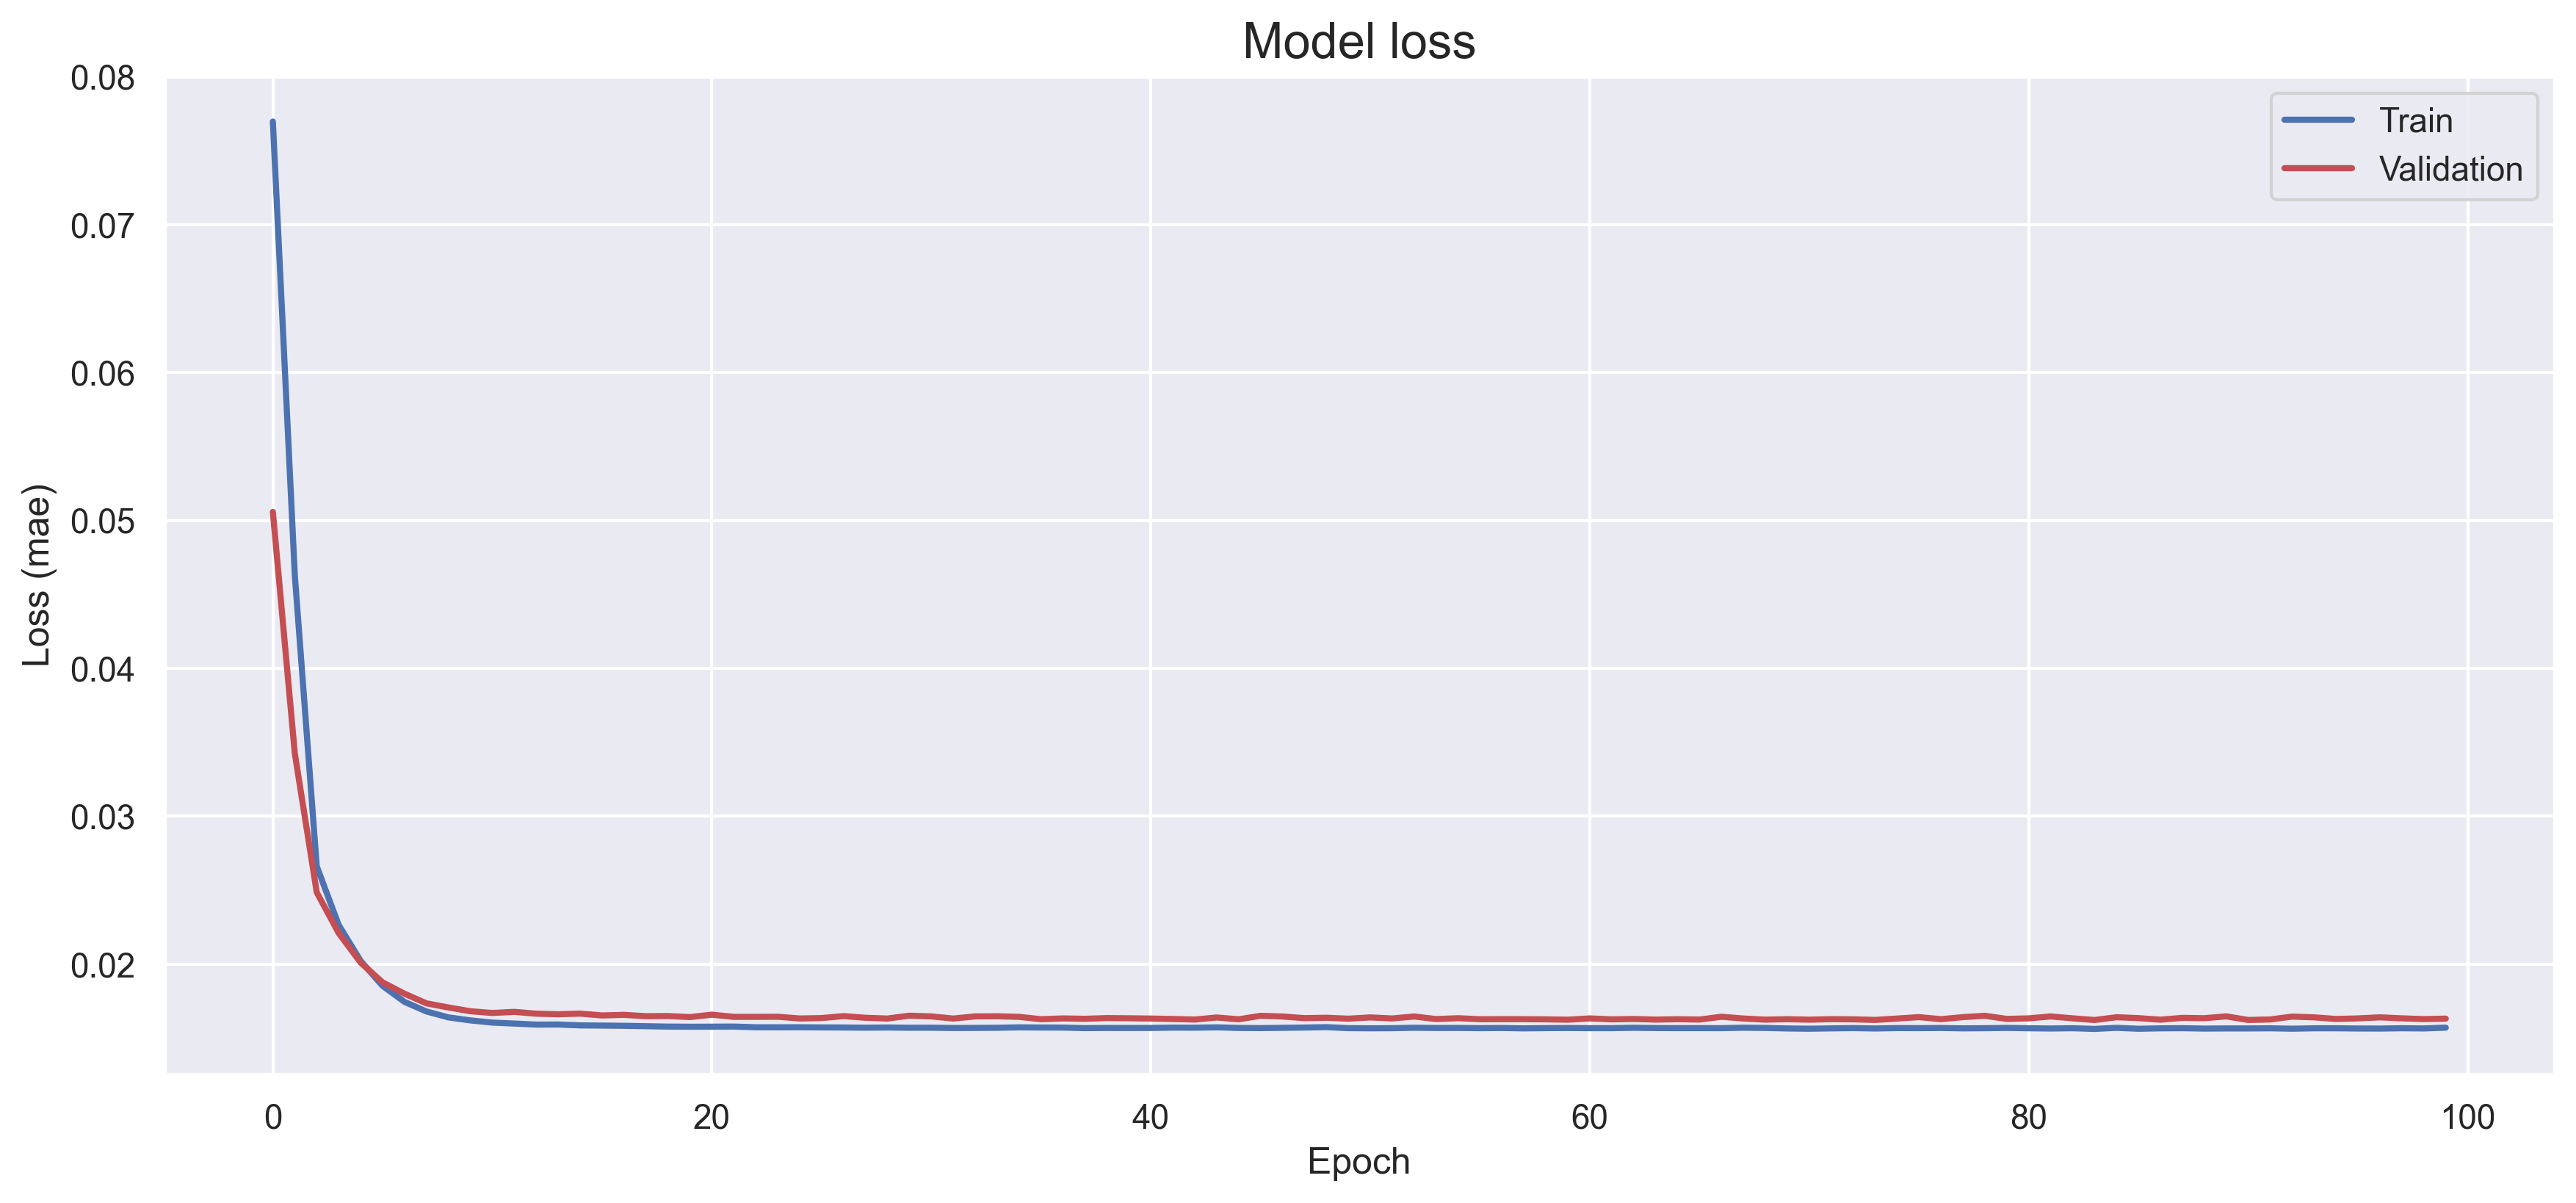

In [105]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=300)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

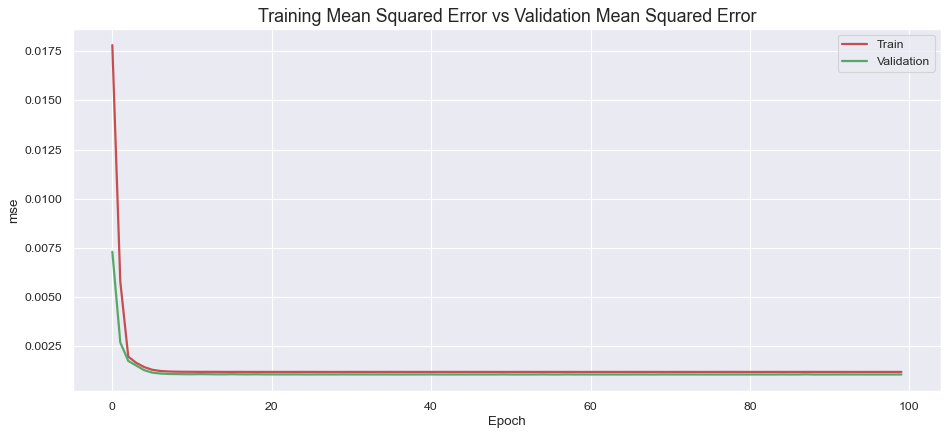

In [106]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['mse'], 'r', label='Train', linewidth=2)
ax.plot(history['val_mse'], 'g', label='Validation', linewidth=2)
ax.set_title('Training Mean Squared Error vs Validation Mean Squared Error', fontsize=16)
ax.set_ylabel('mse')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

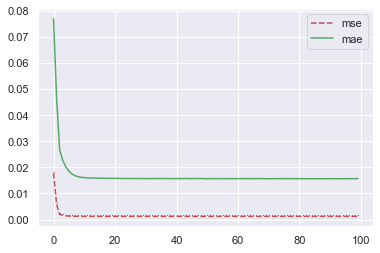

In [107]:
# plot metrics
plt.plot(history['mse'],'r--,', label='mse')
plt.plot(history['mae'],'g', label='mae')
# plt.plot(history['mape'],'y', label='mape')
# plt.plot(history['cosine_proximity'], 'b', label='cosine_proximity')
plt.legend(loc='upper right')
plt.show()

## Distribution of Loss Function

(12048, 1, 3)


(0.0, 0.4)

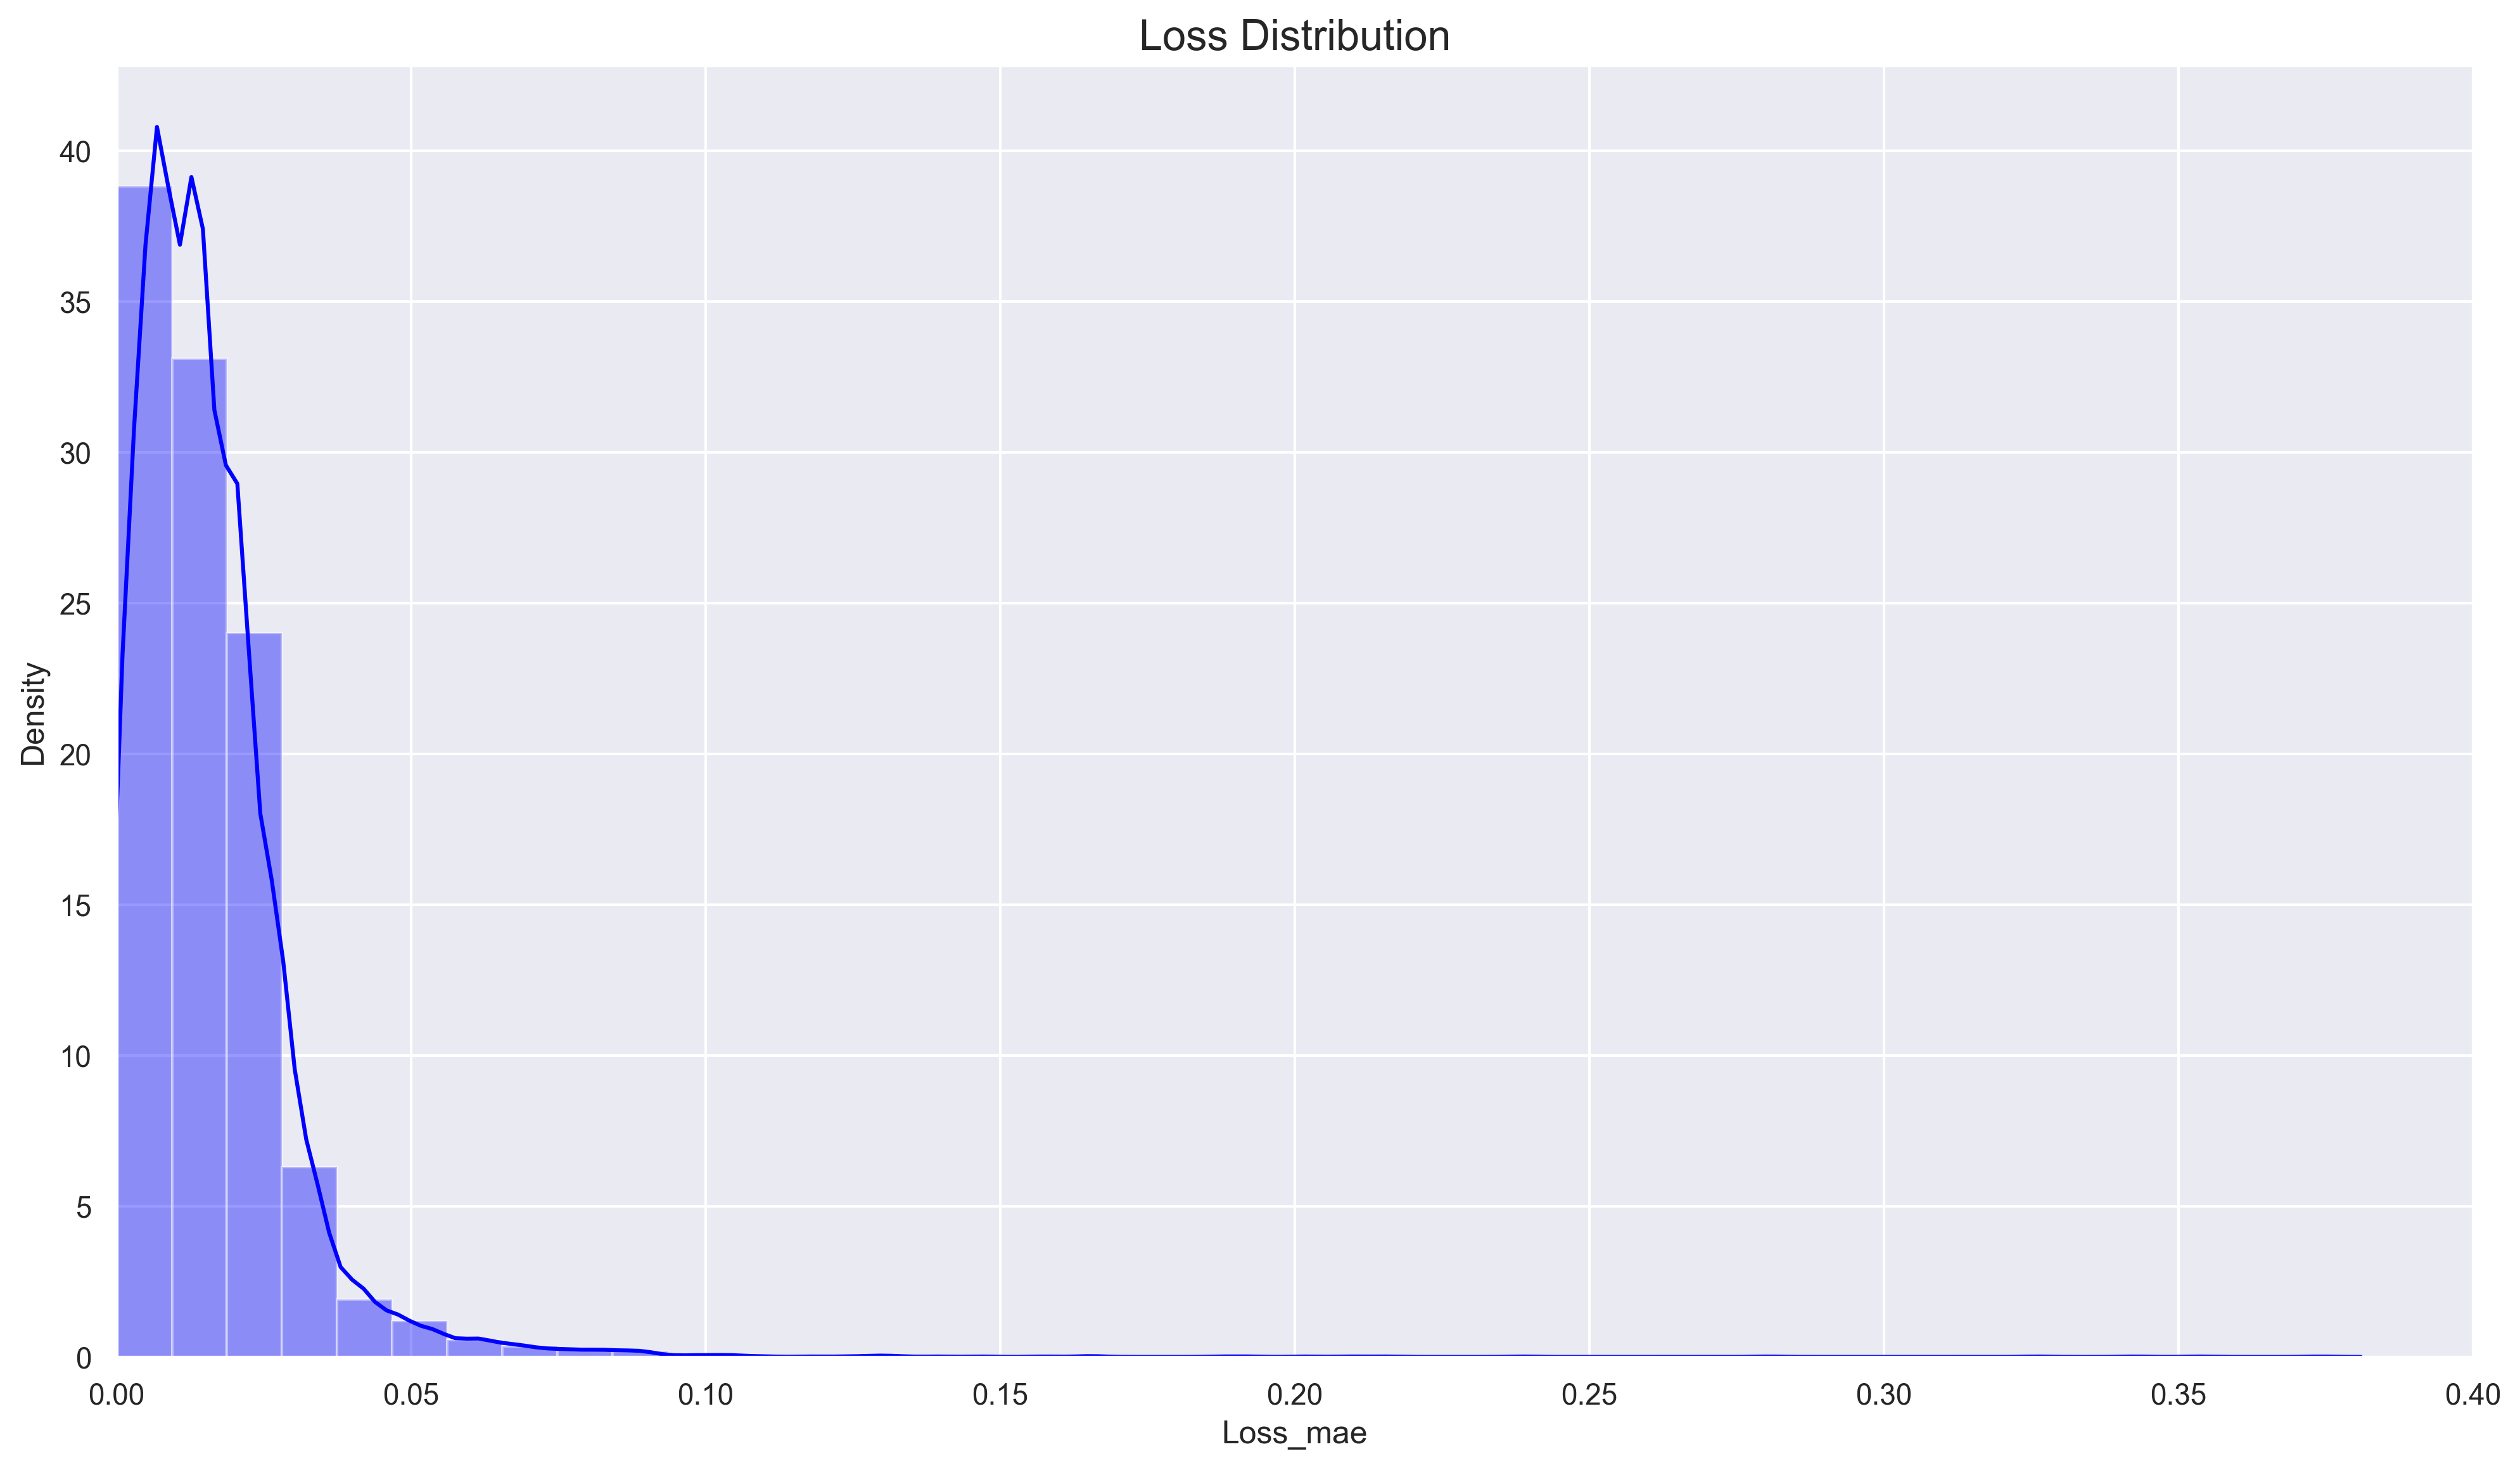

In [110]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
print(X_pred.shape)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi= 300)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 40, kde= True, color = 'blue');
plt.xlim([0.0,.4])

In [ ]:
X_train.shape

In [ ]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.025 # 0.275
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

In [ ]:
scored.info()

In [ ]:
scored.to_csv('FMA.csv', sep=',')

In [ ]:
data_filter = scored[scored['Anomaly'] == True]
data_filter.head(1000)

In [ ]:
data_filter.info()

In [ ]:
data_filter.to_csv('FMA.csv', sep=';')

In [ ]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.025 #0.275
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

Having calculated the loss distribution and the anomaly threshold, we can visualize the model output in the time leading up to the bearing failure.

In [ ]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

In [ ]:
# Get train MAE loss.
x_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(x_train_pred - X_train), axis=1)
plt.figure(figsize=(16,9), dpi= 300)
plt.hist(train_mae_loss, bins= 40)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.xlim([0.0,.25])
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [ ]:
print("TF version:" + tf.__version__)
print(tf.config.list_physical_devices('GPU'))

In [ ]:
X_train.shape

# Version Dago .01
## Determinación de Clasificación.

In [ ]:
# calculate the loss on the test set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index


In [ ]:
error_df = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
error_df['Reconstruction_error'] = np.mean(np.power(X_pred-Xtrain, 2), axis = 1)
error_df['True_class'] = train_fma
error_df.head()

In [ ]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=1)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=1)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [ ]:
## ROC Curve Check

In [ ]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=2, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

## Recall vs. Precision Thresholding

In [ ]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth=2, label='Precision-Recall curve')
plt.legend(loc='lower right')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### Reconstruction Error vs Threshold Check

In [ ]:
threshold_fixed = 0.01
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "FMA" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show(); 

### Confusion Matrix

In [ ]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
sns.kdeplot(error_df.Reconstruction_error[error_df.True_class==0], label='Normal', shade=True, clip=(0,10))
sns.kdeplot(error_df.Reconstruction_error[error_df.True_class==1], label='FMA', shade=True, clip=(0,10))
plt.xlabel('Reconstruction error');
plt.title('Reconstruction error - Train set')


 ### A threshold of XX should provide a reasonable trade-off between precision and recall.

# Version Dago .02
## Determinación de Clasificación. Test

In [ ]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

In [ ]:
error_df = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
error_df['Reconstruction_error'] = np.mean(np.power(X_pred-Xtest, 2), axis = 1)
error_df['True_class'] = test_fma # 0.275
error_df.head()

In [ ]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=1)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=1)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

## ROC Curve Check

In [ ]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=2, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

## Recall vs. Precision Thresholding

In [ ]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth=0.5, label='Precision-Recall curve')
plt.legend(loc='upper right')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

## Grafo

In [ ]:
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=2)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=2)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

### Reconstruction Error vs Threshold Check

In [ ]:
threshold_fixed = 0.01
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "FMA" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show(); 

### Confusion Matrix

In [ ]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
def print_stats(ytest, ypred):
    print("Accuracy: {:.5f}, Cohen's Kappa Score: {:.5f}".format(
        accuracy_score(ytest, ypred), 
        cohen_kappa_score(ytest, ypred, weights="quadratic")))
    ll = log_loss(ytest, ypred)
    print("Log Loss: {}".format(ll))
    print(' ')
    print("Confusion Matrix:")
    print(confusion_matrix(ytest, ypred))
    print("Classification Report:")
    print(classification_report(ytest, ypred))

In [ ]:
# error_df.True_class

In [ ]:
print_stats(error_df.True_class, pred_y)

In [ ]:
p = precision_score(error_df.True_class, pred_y)
r = recall_score(error_df.True_class, pred_y)
f = fbeta_score(error_df.True_class, pred_y, beta= 2)
print('Result: p=%.3f, r=%.3f, f=%.3f' % (p, r, f))

In [ ]:
#Result: p=0.692, r=0.065, f=0.236